In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import *
import pandas as pd

### The Duffing Equation is given by:

$ \dot{x_1} = x_2$

$ \dot{x_2} = -x_1^3+ax_1^2+x_1 - a $

### and the Hamiltonian is given by:

$ H = \frac{x_2^2}{2}+\frac{x_1^4}{4}-\frac{x_1^2}{2}-\frac{a}{3}x_1^3+ax_1$

In [49]:
# define the system ODE

def duffing(t,X,a):
    # define individual ODEs or rates of change
    dx1dt = X[1]
    dx2dt = -X[0]**3+a*X[0]**2+X[0]-a
    # collect rates of change
    dXdt = np.asarray([dx1dt,dx2dt])
    # return the result
    return dXdt


# define the hamiltonian for the system
def Hamiltonian(X,a):
    
    x1 = X[0]; x2 = X[1]
    
    H = (x2**2)/2+(x1**4)/4-(x1**2)/2-a/3*x1**3+a*x1
    
    return H

### Collect Trajectories

In [50]:
dt = 0.001 # time step
tspan = [0, 10] # initial and final time
t_vec = np.arange(0,10,dt) # time vector
x0 = [0, -2.8] # initial condition

a = 0 # parameter for the duffing equation

states = solve_ivp(duffing, tspan, x0, t_eval = t_vec , args = (a,))

t = states.t
X = states.y

Text(0.5, 1.0, 'Duffing System State Evolution')

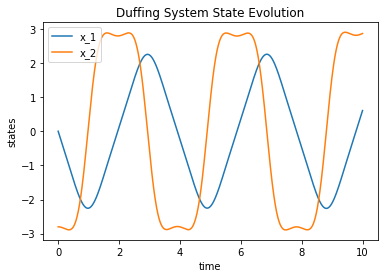

In [51]:
plt.plot(t,states.y[0,:],label = 'x_1')
plt.plot(t,states.y[1,:],label = 'x_2')
plt.legend()
plt.xlabel('time')
plt.ylabel('states')
plt.title('Duffing System State Evolution')

### Identify Koopman Eigenfunction with Lambda = 0 (Hamiltonian) from Full Trajectory for Truth/Reference

In [52]:
Hamilt = [Hamiltonian(X[:,i],a) for i in range(X.shape[1])]

### Compute Derivatives Using Fourth Order Central Difference

In [53]:
def fourth_order_dev(X):
    
    nstates = 2
    dX = np.zeros([nstates,X.shape[1]-4])

    for i in range(nstates):
        dX[i,:] = (1/(12*dt)) * (-X[i,4:] + 8*X[i,3:-1] - 8*X[i,1:-3] + X[i,:-4]) 
        
    X = X[:,2:-2]
    
    return X,dX

In [54]:
X,dX = fourth_order_dev(X)

### Build Theta

In [55]:
def buildTheta(yin,polyorder,usesine):
    
    n = yin.shape[1]
    nVars = yin.shape[0]
    
#     # zero order polynomial (constant)
#     yout = np.ones([n,1])
    
#     # first order polynomial
#     for i in range(nVars):
#         col = np.reshape(yin[i,:],(n,1))
#         yout = np.append(yout,col,axis = 1)
    
    # first entry for first order polynomial
    col = np.reshape(yin[0,:],(n,1))
    yout = col
    
    # first order polynomial
    for i in range(1,nVars):
        col = np.reshape(yin[i,:],(n,1))
        yout = np.append(yout,col,axis = 1)
       
    
    # second oder polynmial 
    if (polyorder >= 2):
        for i in range(nVars):
            for j in range(i,nVars):
                col = np.reshape(yin[i,:]*yin[j,:],(n,1))
                yout = np.append(yout,col,axis = 1)
    
    # third order polynomial
    if (polyorder >= 3):
        for i in range(nVars):
            for j in range(i, nVars):
                for k in range(j, nVars):
                    col = np.reshape(yin[i,:]*yin[j,:]*yin[k,:],(n,1))
                    yout = np.append(yout,col,axis = 1)
    
    # fourth order polynomial
    if (polyorder >= 4):
        for i in range(nVars):
            for j in range(i, nVars):
                for k in range(j, nVars):
                    for l in range(k,nVars):
                        col = np.reshape(yin[i,:]*yin[j,:]*yin[k,:]*yin[l,:],(n,1))
                        yout = np.append(yout,col,axis = 1)
    
    # sines
    if(usesine):
        for i in range(nVars):
            for j in range(1,11):
                col = np.reshape(np.sin(j*yin[i,:]),(n,1))
                yout = np.append(yout,col,axis = 1)
                col = np.reshape(np.cos(j*yin[i,:]),(n,1))
                yout = np.append(yout,col,axis = 1)
                                 
    return yout

### Build Gamma

In [56]:
def buildGamma(yin,ydotin,polyorder,usesine):
    
    n = yin.shape[1]
    nVars = yin.shape[0]
    
#     # derivative of zero order polynomial (constant)
#     yout = np.ones([n,1])
    
#       # derivative of first order polynomial
#     for i in range(nVars):
#         col = np.reshape(ydotin[i,:],(n,1))
#         yout = np.append(yout,col,axis = 1)
    
    # first entry for first order polynomial
    col = np.reshape(ydotin[0,:],(n,1))
    yout = col
    # derivative of first order polynomial
    for i in range(1,nVars):
        col = np.reshape(ydotin[i,:],(n,1))
        yout = np.append(yout,col,axis = 1)
        
    # derivative of second order polynomial
    if (polyorder >= 2):
        for i in range(nVars):
            for j in range(i,nVars):
                col = np.reshape(ydotin[i,:]*yin[j,:]+yin[i,:]*ydotin[j,:],(n,1))
                yout = np.append(yout,col,axis = 1)
    
    # third order polynomial
    if (polyorder >= 3):
        for i in range(nVars):
            for j in range(i, nVars):
                for k in range(j, nVars):
                    col = (np.reshape(ydotin[i,:]*yin[j,:]*yin[k,:]+yin[i,:]*ydotin[j,:]*yin[k,:]
                                      +yin[i,:]*yin[j,:]*ydotin[k,:],(n,1)))
                    yout = np.append(yout,col,axis = 1)
                    
    # fourth order polynomial
    if (polyorder >= 4):
        for i in range(nVars):
            for j in range(i, nVars):
                for k in range(j, nVars):
                    for l in range(k,nVars):
                        col = (np.reshape(ydotin[i,:]*yin[j,:]*yin[k,:]*yin[l,:]
                                          +yin[i,:]*ydotin[j,:]*yin[k,:]*yin[l,:]
                                          +yin[i,:]*yin[j,:]*ydotin[k,:]*yin[l,:]
                                          +yin[i,:]*yin[j,:]*yin[k,:]*ydotin[l,:],(n,1)))
                        yout = np.append(yout,col,axis = 1)
    
    
    # sines
    if(usesine):
        for i in range(nVars):
            for j in range(1,11):
                col = np.reshape(np.sin(j*yin[i,:]),(n,1))
                yout = np.append(yout,col,axis = 1)
                col = np.reshape(np.cos(j*yin[i,:]),(n,1))
                yout = np.append(yout,col,axis = 1)
                
    
    return yout


In [57]:
Theta = buildTheta(X,4,False)
Gamma = buildGamma(X,dX,4,False)

### Compute the Co-efficients Vector Using Different Methods

In [58]:
# Method 1 - SVD
U,Sigma,VT = np.linalg.svd(0*Theta-Gamma,full_matrices=0)
V = VT.T

xi0 = V[:,-1]
thresh_xi0 = np.where(np.abs(xi0) < 1e-4)
xi0[thresh_xi0[0]] = 0

## Method 2 - LS
K = np.matmul(np.linalg.pinv(Theta),Gamma)
thresh_ind = np.where(np.abs(K) < 1e-12)
K[thresh_ind] = 0
[D,T] = np.linalg.eig(K)
IX = np.argsort(np.abs(D))

xi1 = T[:,IX[0]]
thresh_xi1 = np.where(np.abs(xi1) < 1e-4)
xi1 = np.real(xi1)
xi1[thresh_xi1[0]] = 0

# combine the co-efficients obtianed from the two different methods
xi = np.vstack([xi0,xi1]).T

In [59]:
xi_pd = pd.DataFrame(data = xi, columns = ['xi0 - SVD','xi1 - LS'])
xi_pd.head(14)

,xi0 - SVD,xi1 - LS
0,0.003534,0.005341
1,0.001541,0.001651
2,-0.641686,-0.607001
3,0.000749,0.000349
4,0.691727,0.722471
5,-0.000762,-0.001076
6,-0.000218,-0.000238
7,-0.000415,-0.000529
8,0.000000,0.000000
9,0.331243,0.330887


In [60]:
V_pd = pd.DataFrame(data = V)
V_pd.head(14)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.002312,7.487829e-04,-0.004897,0.000318,-0.000893,0.010928,-0.000692,0.102589,0.151225,0.020485,0.007192,0.982093,0.038292,0.003534
1,0.000012,-1.005440e-02,0.000317,-0.004761,-0.088173,-0.000346,-0.131466,0.001252,-0.003240,-0.180449,-0.970618,0.010888,0.004843,0.001541
2,0.041640,7.573556e-04,0.030910,-0.000136,-0.000435,0.001137,-0.001755,-0.190986,0.125785,0.003116,0.001372,-0.025401,0.729788,-0.641686
3,-0.000361,1.093771e-01,-0.001109,-0.143796,0.026616,0.002031,-0.020895,-0.000393,0.003423,0.966151,-0.179884,-0.019201,-0.004600,0.000749
4,-0.097493,-3.532295e-04,0.088243,-0.000593,0.000738,0.015431,0.001631,0.180430,-0.115645,0.003293,0.003883,-0.029947,0.676113,0.691727
5,-0.023934,3.713801e-07,0.008836,-0.000442,0.000339,-0.295598,-0.004932,0.512556,0.787320,-0.005957,-0.002066,-0.171097,-0.006721,-0.000762
6,-0.000259,-3.217380e-02,0.001243,0.097084,-0.072922,0.007545,-0.982486,0.004435,-0.006016,0.023974,0.135096,-0.001837,-0.000818,-0.000218
7,0.025385,6.876188e-03,-0.126927,0.004808,-0.010512,0.946520,0.007194,0.152009,0.244593,-0.004046,-0.001097,-0.064467,-0.002509,-0.000415
8,0.000114,-9.071475e-02,0.003226,-0.253016,-0.957968,-0.008043,0.060157,-0.000121,-0.002248,0.014884,0.078286,-0.001079,-0.000453,0.000000
9,0.278659,2.037742e-03,-0.114810,0.000711,-0.002080,-0.028259,-0.006852,-0.748944,0.487506,-0.002517,-0.000503,0.002408,0.000312,0.331243


In [61]:
eigen_func1 = np.dot(Theta,xi0)
norm1 = np.linalg.norm(eigen_func1)
eigen_func1n = eigen_func1/norm1

eigen_func2 = np.dot(Theta,xi1)
norm2 = np.linalg.norm(eigen_func2)
eigen_func2n = eigen_func2/norm2

norm_hamil = np.linalg.norm(Hamilt[:X.shape[1]])
Hamil_normalized = Hamilt[:X.shape[1]]/norm_hamil


new_t = t[:X.shape[1]]

Text(0.5, 1.0, 'Un-normalized')

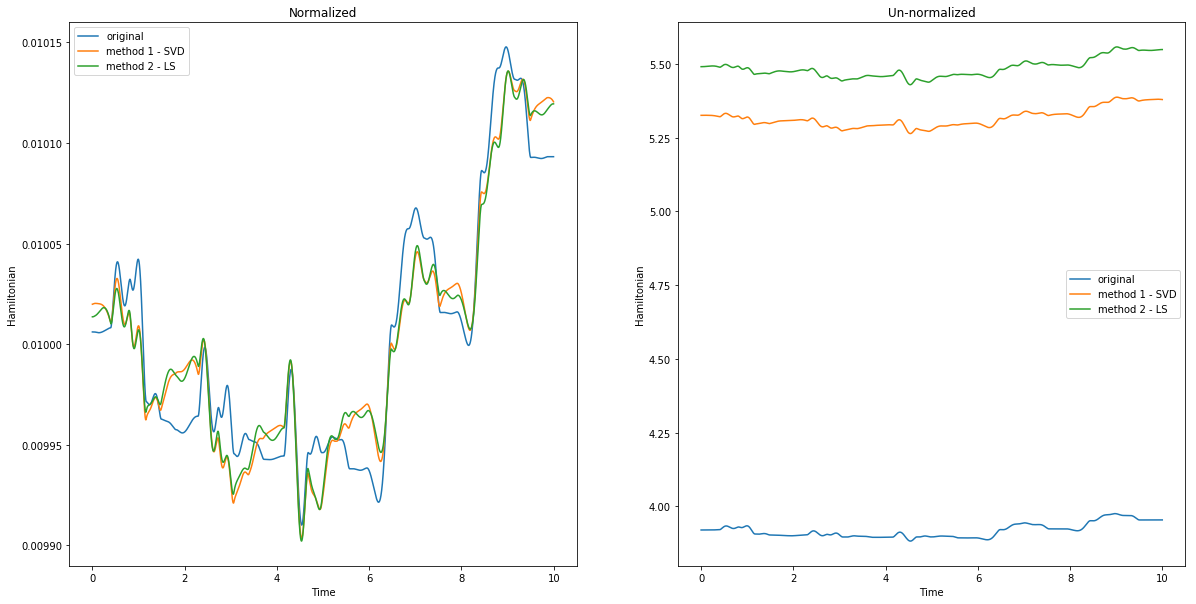

In [62]:
f = plt.figure(figsize=(20,10))

f.add_subplot(1,2,1)
plt.plot(new_t,Hamil_normalized, label = 'original')
plt.plot(new_t,eigen_func1n, label = 'method 1 - SVD')
plt.plot(new_t,eigen_func2n, label = 'method 2 - LS')
plt.legend()
plt.ylabel('Hamiltonian')
plt.xlabel('Time')
plt.title('Normalized')

f.add_subplot(1,2,2)
plt.plot(new_t,Hamilt[:X.shape[1]], label = 'original')
plt.plot(new_t,eigen_func1, label = 'method 1 - SVD')
plt.plot(new_t,eigen_func2, label = 'method 2 - LS')
plt.legend()
plt.ylabel('Hamiltonian')
plt.xlabel('Time')
plt.title('Un-normalized')